<h1><center>Convex Optimization - Barrier Method - Jed HOUAS</center></h1>

In [264]:
import numpy as np
import pandas as pd
import numpy.linalg as linalg
import matplotlib.pyplot as plt

In [297]:
def objective(Q,p,A,b,t,v):
    res = t*np.transpose(v).dot(Q).dot(v) + t*np.transpose(p).dot(v)
    for i in range(A.shape[0]):
        res = res - np.log(b[i]-np.dot(A,v)[i])
    return(res)
def gradient_QP(Q,p,A,b,t,v):
    res= 2*t*np.dot(Q,v) + t*p
    for i in range(A.shape[0]):
        res = res + (1/(b[i]-np.dot(A,v)[i]))*np.transpose(A)[:,i].reshape((len(v),1))
    return(res)

def Hessien_QP(Q,p,A,b,t,v):
    res = 2*t*Q
    for i in range(A.shape[0]):
        Eii = np.zeros((A.shape[0],A.shape[0]), dtype=float)
        Eii[i,i] = 1
        res = res + (1/(b[i]-np.dot(A,v)[i])**2)*np.transpose(A).dot(Eii).dot(A)
    return(res)
        
def centering_step(Q,p,A,b,t,v0,eps):
    v = [v0]
    alpha = 0.05
    beta = 0.5
    lbd2 = np.transpose(gradient_QP(Q,p,A,b,t,v[-1])).dot(linalg.inv(Hessien_QP(Q,p,A,b,t,v[-1]))).dot(gradient_QP(Q,p,A,b,t,v[-1]))
    while lbd2/2 > eps:
        #print(lbd2)
        delta_x = -linalg.inv(Hessien_QP(Q,p,A,b,t,v[-1])).dot(gradient_QP(Q,p,A,b,t,v[-1]))
        step = 1
        new = v[-1]+step*delta_x
        i=1
        # Step backtracking:
        while (i<100) and np.all((b-np.dot(A,new))>0) and (objective(Q,p,A,b,t,new)>= objective(Q,p,A,b,t,v[-1]) + alpha*step*np.transpose(gradient_QP(Q,p,A,b,t,v[-1])).dot(delta_x)) :
            #print((objective(Q,p,A,b,t,new)>= objective(Q,p,A,b,t,v[-1]) + alpha*step*np.transpose(gradient_QP(Q,p,A,b,t,v[-1])).dot(delta_x)))
            step = beta*step
            new = v[-1]+step*delta_x
            i = i+1
        v.append(new)
        lbd2 = np.transpose(gradient_QP(Q,p,A,b,t,v[-1])).dot(linalg.inv(Hessien_QP(Q,p,A,b,t,v[-1]))).dot(gradient_QP(Q,p,A,b,t,v[-1]))

    return(v)
        
        

### Checking the centering function

In [298]:
Q = 0.5*np.eye(10,10)
p = np.random.rand(10,1)
A = np.random.rand(10,10)
b = np.random.rand(10,1)
v0= -np.random.rand(10,1)
eps = 0.001

vs = centering_step(Q,p,A,b,1,v0,eps)

In [299]:
vs[-1]

array([[-1.44261778],
       [-1.4831635 ],
       [-0.94879981],
       [-0.77275916],
       [-1.59542381],
       [-1.20614254],
       [-1.87595595],
       [-1.02742655],
       [-1.52782486],
       [-1.16973962]])

### 3. Barrier Method implementation:

In [300]:
def barr_method(Q,p,A,b,v0,eps,mu):
    m = A.shape[0]
    t = 1
    process = dict({})
    process[t] = centering_step(Q,p,A,b,t,v0,eps)
    v = [v0, process[t][-1]]
    while m/t >= eps:
        t = mu*t
        process[t] = centering_step(Q,p,A,b,t,v[-1],eps)
        v.append(process[t][-1])
        #print(t)
        
    return(v, process)
    

In [301]:
eps = 0.001
sol, process = barr_method(Q,p,A,b,v0,eps,15)

In [302]:
process.keys()

dict_keys([1, 15, 225, 3375, 50625])

In [303]:
process[50625]

[array([[-0.74619782],
        [-0.81497463],
        [-0.24520286],
        [-0.14521193],
        [-0.95799555],
        [-0.58340378],
        [-0.98410371],
        [-0.29152973],
        [-0.96393395],
        [-0.38647462]]), array([[-0.74581075],
        [-0.81460318],
        [-0.24480952],
        [-0.14485574],
        [-0.95765122],
        [-0.58306697],
        [-0.98360162],
        [-0.29111603],
        [-0.96362582],
        [-0.38603848]])]

### Checking the barrier method function:

In [308]:
# I randomly generate vectors v and evaluate the function on them, and verify if my minimum found is always lower
X = [i for i in range(1,10000)]
Y = []
i = 1
while i < 10000:
    v = -100*np.random.rand(10,1)
    if np.all((b-np.dot(A,v))>0):
        Y.append((np.transpose(v).dot(Q).dot(v) + np.transpose(p).dot(v))[0,0])
        i = i+1
Z = [(np.transpose(sol[-1]).dot(Q).dot(sol[-1]) + np.transpose(p).dot(sol[-1]))[0,0] for i in range(1,10000)]

Verifying constrain on the solution found:  True


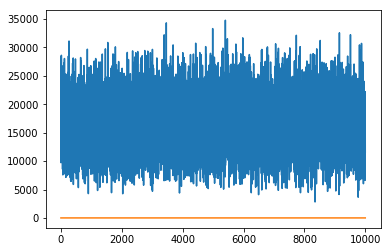

In [309]:
print("Verifying constrain on the solution found: ", np.all((b-np.dot(A,sol[-1]))>0))
plt.plot(X,Y)
plt.plot(X,Z)
plt.show()

### 3. Testing the code:

#### Create random data

In [331]:
y = 100*np.random.rand(10,1)
X = 100*np.random.rand(10,50)
lbd = 10

Q = 0.5*np.eye(10,10)
A = np.concatenate((np.transpose(X), -np.transpose(X)), axis=0)
b = lbd*np.ones((2*50,1))
v0= -np.random.rand(10,1)
eps = 0.0001


In [333]:
sol, process = barr_method(Q,p,A,b,v0,eps,15)

#### Plot  barrier steps v* gap:

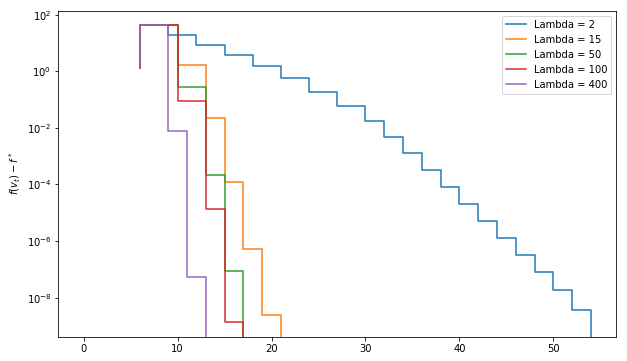

In [340]:
plt.figure(figsize=(10,6)) 
for mu in [2,15,50,100,400]:
    sol, process = barr_method(Q,p,A,b,v0,eps,mu)
    gap_finalSol = [(np.transpose(v).dot(Q).dot(v) + np.transpose(p).dot(v))[0,0] - (np.transpose(sol[-1]).dot(Q).dot(sol[-1]) + np.transpose(p).dot(sol[-1]))[0,0]  for v in sol]             
    process_list = [len(process[t]) for t in process.keys()]
    nbre_iter = [sum(process_list[:i]) for i in range(1,len(process_list)+1)]
    nbre_iter.append(0)
    plt.step(nbre_iter, gap_finalSol, label="Lambda = "+str(mu))
                    
plt.semilogy()
plt.legend()
plt.ylabel('$f(v_t)-f^*$')
plt.show()

#### Plot all steps (within the newton method of each barrier step) gap:

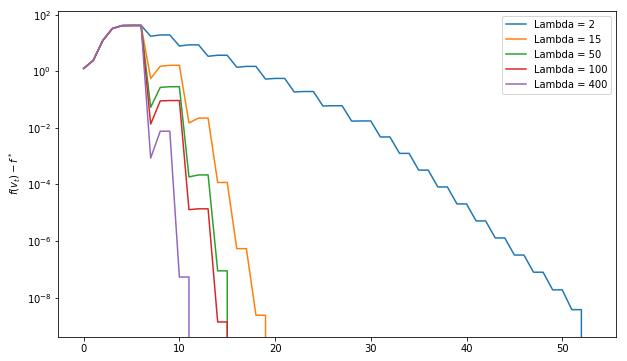

In [346]:
plt.figure(figsize=(10,6)) 
for mu in [2,15,50,100,400]:
    sol, process = barr_method(Q,p,A,b,v0,eps,mu)
    gap_finalSol = []
    for t in process.keys():
        l = [(np.transpose(v).dot(Q).dot(v) + np.transpose(p).dot(v))[0,0] - (np.transpose(sol[-1]).dot(Q).dot(sol[-1]) + np.transpose(p).dot(sol[-1]))[0,0]  for v in process[t]]
        gap_finalSol = gap_finalSol + l
        
    plt.plot(np.arange(len(gap_finalSol)), gap_finalSol, label="Lambda = "+str(mu))
                    
plt.semilogy()
plt.legend()
plt.ylabel('$f(v_t)-f^*$')
plt.show()